<a href="https://colab.research.google.com/github/su-sumico/seminar/blob/main/GIS3_CoordinateReferenceSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 測地系と投影座標系
ここまで Point や Polygon の座標を与えてきたが，その単位を明らかにしていない。

測地系とは「緯度経度の座標軸を使って，地図画面上の特定の位置を示す際の基準となる前提条件」と定義されている。例えば，地球の表面を曲面として捉えるか，（狭い地域において）平面と捉えるか，その辺りのルールを定めていると考えればよい。

- 日本の測地系として「日本測地系2000 (JGD 2000)」や「日本測地系2011 (JGD 2011)」が知られている。
- 投影座標系として「緯度経度」や「平面直角座標」がメジャーである。

これらの測地系と投影座標系の組み合わせに対して，
EPSGコードが割り当てられており，
- 測地系 "JGD2000" と "緯度経度" の組み合わせは EPSG:4612
- 測地系 "JGD2000" と "平面直角座標" の組み合わせは EPSG:2443 である。

以上について，よくまとまっているサイトを以下に示す：

GISのための測地成果、測地系、楕円体、投影座標系、EPSGコードのまとめ
https://tmizu23.hatenablog.com/entry/20091215/1260868350


#### （参考）測地系を詳しく知りたい方は下記を参照してください。

GIS基礎解説：測地系＠ESRIジャパン

https://www.esrij.com/gis-guide/coordinate-and-spatial/datum/


(注) CRS = Coordinate Reference System



### (準備) geopandas のインストール

In [1]:
# geopandas のインストール
!pip install geopandas

### (準備) Google Drive のマウント

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 測地系の設定例
- geopandas に含まれるデータセット "naturalearth_lowres" は
"EPSG:4326" であり，測地系は "WGS84系"，投影座標は "緯度経度" である。
- ESRIジャパンの提供する全国市区町村界データは（ちょっと）分かりにくいが，楕円体が "GRS80" ('ellips':'GRS80') であるから測地系は "JGD2000"である。また，Axis Info (ellipsoidal) より投影座標系が「緯度経度」であることが分かる。

In [3]:
# geopandas に含まれるデータセット "naturalearth_lowres"
import geopandas as gpd

dataset = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(dataset)

world.crs

<ipython-input-3-da69d78f3e5a>:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  dataset = gpd.datasets.get_path('naturalearth_lowres')


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

全国市区町村界データ: https://www.esrij.com/products/japan-shp/

In [4]:
# ESRIジャパンの提供する全国市区町村界データ
path = r'/content/drive/My Drive/japan_ver84/japan_ver84.shp'
japan = gpd.read_file(path, encoding='shiftjis')

# 測地系データの表示
japan.crs

<Geographic 2D CRS: EPSG:6668>
Name: JGD2011
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Japan - onshore and offshore.
- bounds: (122.38, 17.09, 157.65, 46.05)
Datum: Japanese Geodetic Datum 2011
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## 測地系・投影座標系を指定して GeoDataFrame を作る

In [5]:
# 必要なライブラリのインポート
import geopandas as gpd
from shapely.geometry import Point

# Point(点)の定義
point1 = Point(131.473843, 34.178295) # 山口市
point2 = Point(131.246816, 33.951555) # 宇部市

# 点を GeoDataFrame の grometry 列へ格納
# ここで測地系・投影座標系としてそれぞれ JGD2000，緯度経度を指定している。
# これに対応する EPSG コードは "4612" である
points = gpd.GeoDataFrame([[point1], [point2]],
                          columns=['geometry'],
                          crs='EPSG:4612')

In [6]:
# 値が正しく格納されているか，確認
points

,geometry
0,POINT (131.47384 34.17829)
1,POINT (131.24682 33.95155)


In [7]:
# GeoDataFrame "points" から２点の geometry を取り出し，距離を求める
p1 = points.loc[0].geometry
p2 = points.loc[1].geometry
p1.distance(p2)

0.32086178695662154

In [8]:
# (参考) いわゆる２点間の距離を求める公式
import math
math.sqrt((131.473843 - 131.246816)**2 + (34.178295 - 33.951555)**2)

0.32086178695662154

上記で得られた距離 0.3208 は緯度・経度を単位とした場合の距離である。

しかし，これでは山口市～宇部市間の距離が何メートルか。分からない。

そこで，測地系・投影座標系を変換する。

## 測地系・投影座標系の変換および直線距離の算出
下記では測地系を JGD2000，投影座標系を平面直角座標系へ変換している。
当該のEPSGコードは "2445" である。

In [9]:
'''
当初，Windows で下記の最初のコードが動かなかったが，
$ conda update --all
$ conda install -c conda-forge geopandas
とすることにより動くようになった。(2020.10.20)
なお，Ubuntu および Google Colab でもは問題なく動く！（実質的に Linux だから？）
'''
new_points = points.to_crs('EPSG:2445', inplace=False)

In [10]:
new_points

,geometry
0,POINT (-63866.520 -201866.896)
1,POINT (-85021.301 -226850.935)


In [11]:
# 型の確認・・・授業の際は不要
print(type(point1))
print(type(new_points.loc[0]))
print(type(new_points.loc[0].geometry))

<class 'shapely.geometry.point.Point'>
<class 'pandas.core.series.Series'>
<class 'shapely.geometry.point.Point'>


In [12]:
# Point 間の距離を求める
new_points.loc[0].geometry.distance(new_points.loc[1].geometry)

32737.241112831663

### 以上より，山口市・宇部市間の直線距離は 32737メートル，すなわち 32.736キロメートルと分かった！

## (参考) 投影座標系の違いを「山口県の地図」で見てみる
GSRIジャパンの提供する全国市区町村界データから山口県を切り出し，検証する。

なお，全国市区町村界データの投影座標系は「緯度経度」である。

In [13]:
import geopandas as gpd

# 全国市区町村界データの読み込み
path = r'/content/drive/My Drive/japan_ver84/japan_ver84.shp'
japan = gpd.read_file(path, encoding='shiftjis')

# 山口県のみ抽出
yamaguchi = japan[japan['KEN']=='山口県']

「緯度経度」座標系の下で可視化した結果を以下に示す。ここで軸目盛りに注意すること！

<Axes: >

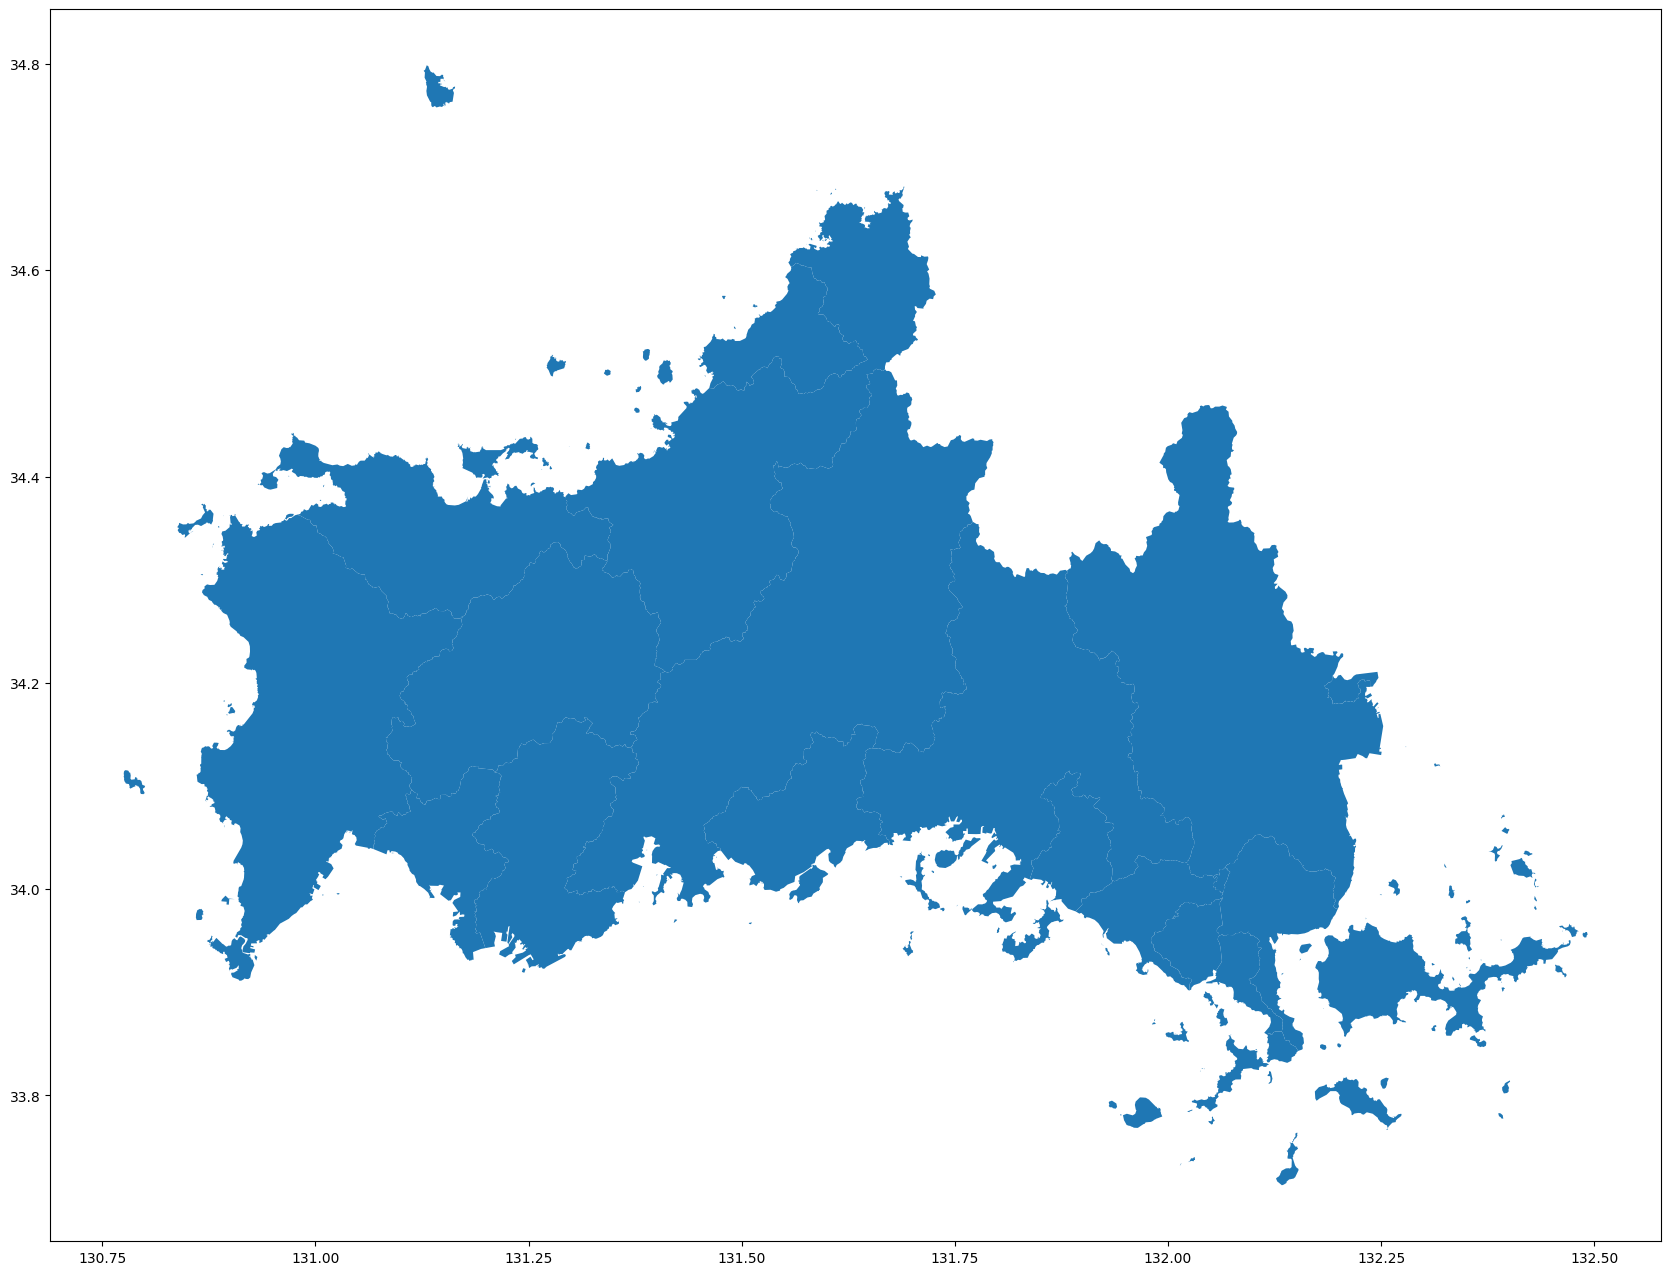

In [14]:
yamaguchi.plot(figsize=(32, 16))

In [15]:
yamaguchi.crs

<Geographic 2D CRS: EPSG:6668>
Name: JGD2011
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Japan - onshore and offshore.
- bounds: (122.38, 17.09, 157.65, 46.05)
Datum: Japanese Geodetic Datum 2011
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [16]:
# 投影座標系の変換

# 日本の場合はこれ！
# GISのための測地成果、測地系、楕円体、投影座標系、EPSGコードのまとめ
# https://tmizu23.hatenablog.com/entry/20091215/1260868350
projected_yamaguchi = yamaguchi.to_crs('EPSG:2445', inplace=False)

<Axes: >

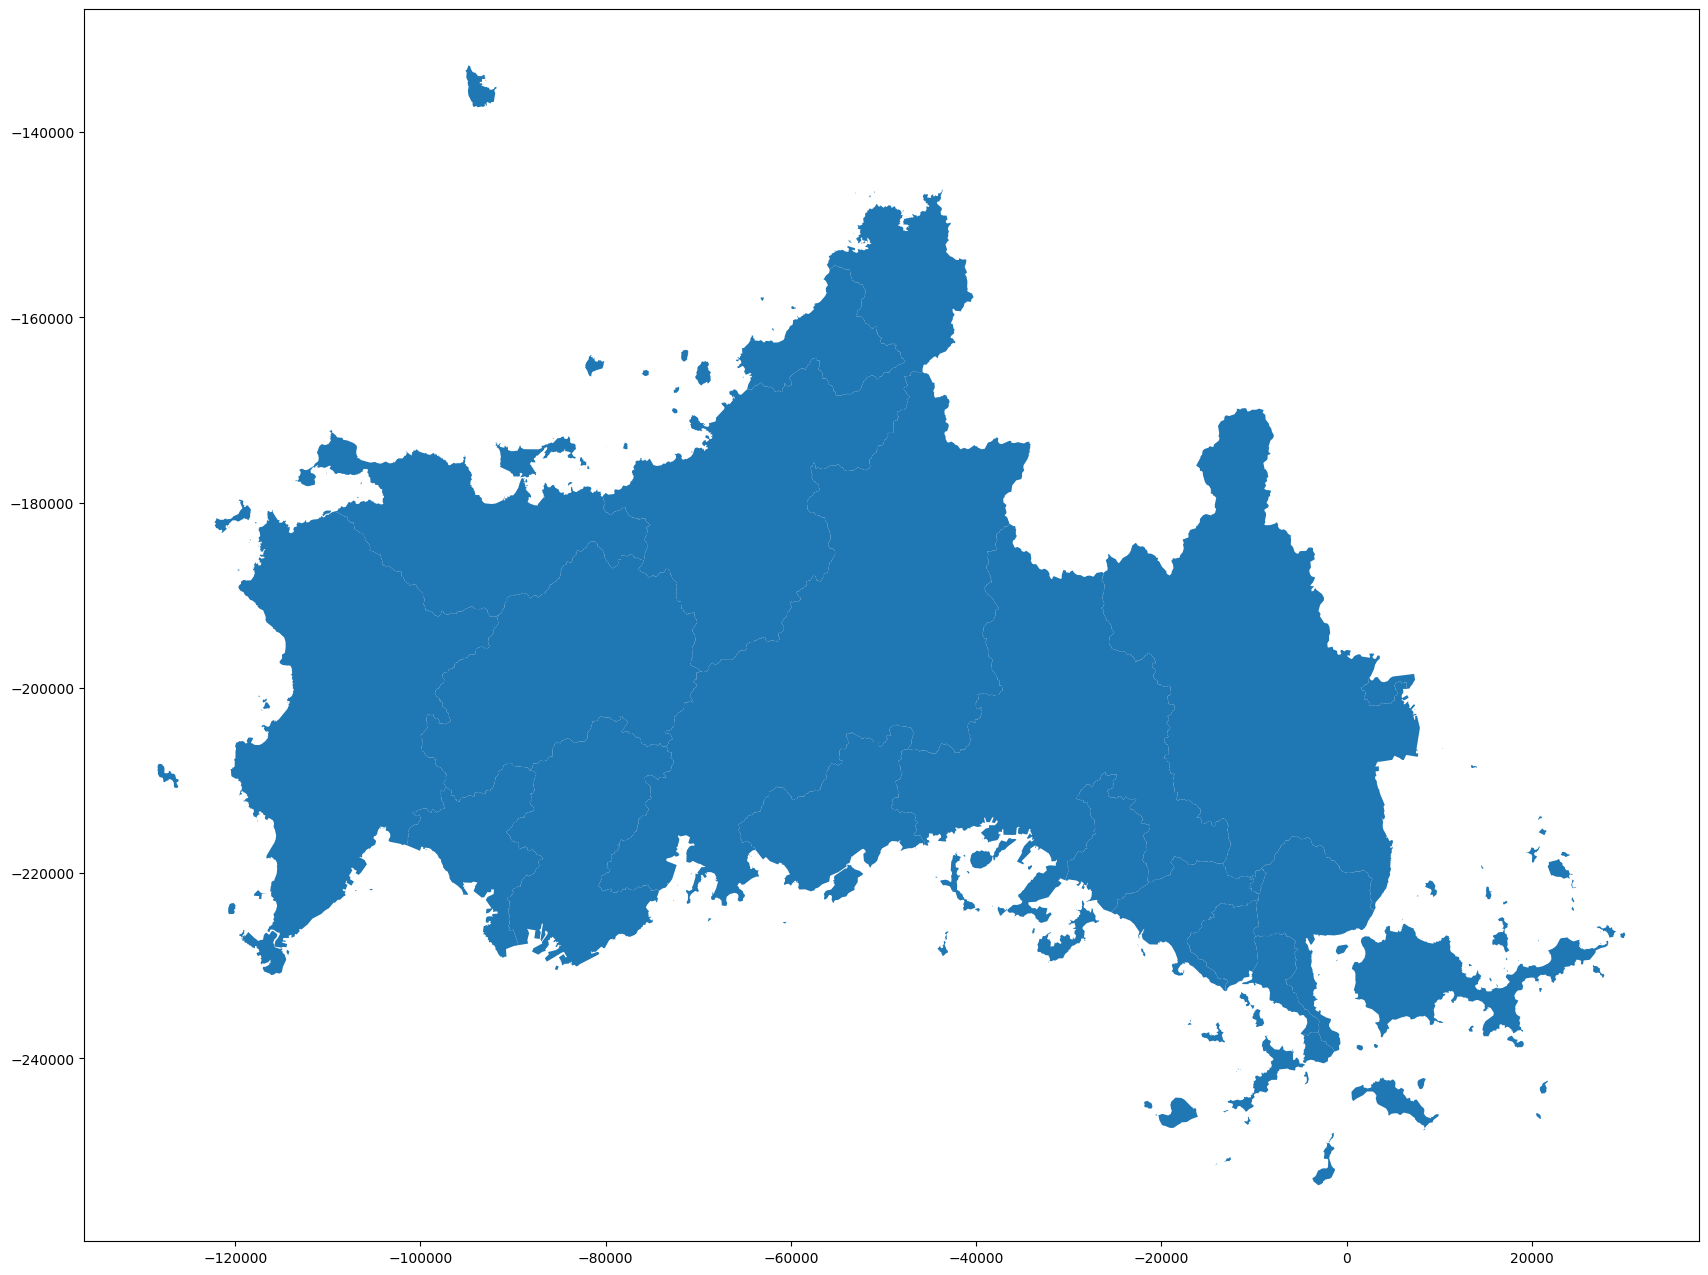

In [17]:
projected_yamaguchi.plot(figsize=(32, 16))